# March 13th, 2021

**Motivation**: Pearson vs Spearman correlations.  The effect of different values of thresholding is studied.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm

import community
import matplotlib.pyplot as plt


def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def plot_graph(g, partition):
    # if partition is None: partition = community.best_partition(g, resolution=1.0)
    pos = community_layout(g, partition)

    plt.figure(figsize=(8, 6))
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap='Accent', node_color=list(partition.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.2)

    plt.tight_layout()
    plt.show()
    
    return


In [68]:
def filter_islands(partition, labels, scale: int, min_com_size: int = 5):
    coms_ctr = collections.Counter(partition.values())
    good_com_idxs = tuple(zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common())))[0]
    
    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)

    comm_mat = np.ones((scale, scale)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        com_idx = partition[node_idx]
        if com_idx in good_com_idxs:
            comm_mat[i, j] = good_com_idxs.index(com_idx)
        else:
            comm_mat[i, j] = np.nan
            
    return comm_mat, comm_dict

## Simple analysis

I choose a dataset that looks OK from subject named **sub-SLC08**.

In [3]:
# HIDE CODE


expt_seconds = 600   # 600 seconds
ca_frequency = 10
exclude_seconds = 50
good_timepoints = (expt_seconds - exclude_seconds) * ca_frequency

filter_fn = lambda x: 'ca' in x and 'ses-1' in x and 'sub-SLC06' in x and 'rest' in x
files = sorted(list(filter(filter_fn, os.listdir(processed_dir))))

data_list = []
for load_filename in files:
    ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
    data_list.append(ca[..., 0, range(ca.shape[-1] - good_timepoints, ca.shape[-1])])
ca = np.concatenate(data_list, axis=-1)

print("Data from {:d} runs loaded:\n".format(len(files)))
pprint(files)

msg = '\n{:d} seconds excluded from the beginning of each run. Combined runs duration:'
msg = msg.format(exclude_seconds)
print(msg)
convert_time(ca.shape[-1] / ca_frequency)

Data from 4 runs loaded:

['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-7_task-rest_ca.npy']

50 seconds excluded from the beginning of each run. Combined runs duration:

00 - 00:36:40  (dd - hh:mm:ss)



## Correlation analysis

Take a source signal from one of the "voxels" and compute its correlation with every other point. We should not call these voxels because this is different than fMRI data.  But then if not voxels, what should we call them for Ca data?

Anyway, I take signal from point (128, 128) on cortex surface and compute its correlation with every other point.  Here is how this correlation result looks like.

In [5]:
bad_x_indices = np.where(ca.mean(-1).mean(1) == 0)[0]
bad_y_indices = np.where(ca.mean(-1).mean(0) == 0)[0]
ca = np.delete(np.delete(ca, bad_y_indices, axis=1), bad_x_indices, axis=0)
ca.shape

(190, 186, 22000)

### Downsample

In [6]:
size = 16
widths = [int(np.ceil(item / size)) for item in ca.shape[:2]]
nt = ca.shape[-1]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(16, 16, 22000)

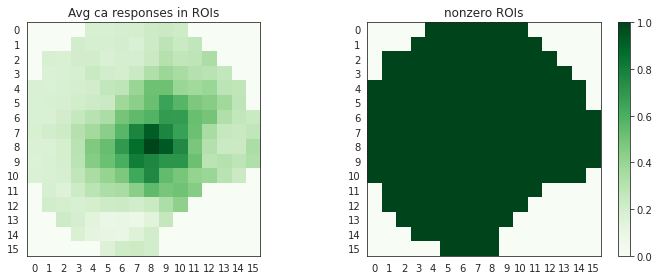

In [8]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[data>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [10]:
pearson_corr = df.corr('pearson').values
spearman_corr = df.corr('spearman').values

np.fill_diagonal(pearson_corr, 0)
np.fill_diagonal(spearman_corr, 0)

thresholds = [0., 0.2, 0.4, 0.6, 0.8, 0.9]
pearson, spearman = {}, {}
for th in thresholds:
    pmat = pearson_corr.copy()
    smat = spearman_corr.copy()
    pmat[pmat<th] = 0.
    smat[smat<th] = 0.
    pearson[th] = pmat
    spearman[th] = smat

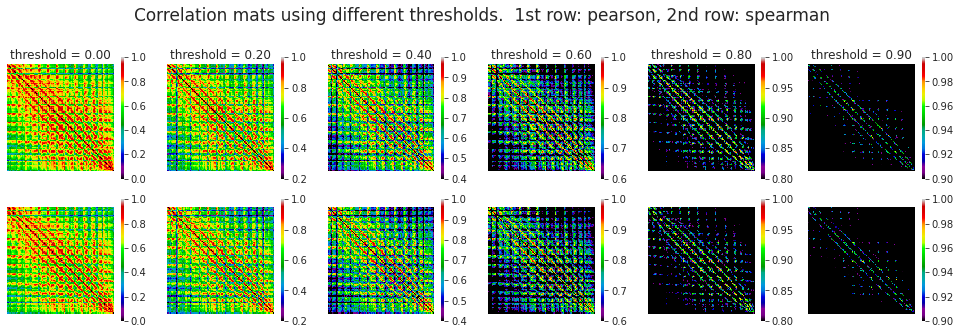

In [11]:
fig, axes = plt.subplots(2, len(thresholds), figsize=(13.5, 4.5))

for i, th in enumerate(thresholds):
    sns.heatmap(
        pearson[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40},
        ax=axes[0, i]
    )
    axes[0, i].set_aspect('equal')
    axes[0, i].set_axis_off()
    axes[0, i].set_title('threshold = {:.2f}'.format(th))
    sns.heatmap(
        spearman[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40},
        ax=axes[1, i]
    )
    axes[1, i].set_aspect('equal')
    axes[1, i].set_axis_off()

msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
fig.suptitle(msg, y=1.02, fontsize=17)
fig.tight_layout()
plt.show()

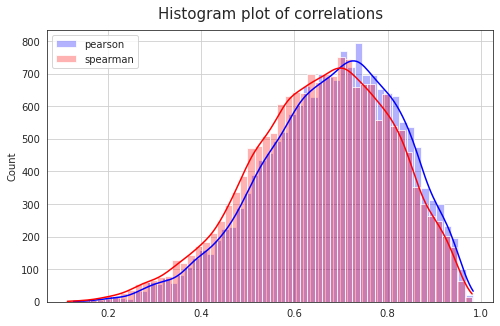

In [12]:
xp = np.triu(pearson_corr)
xs = np.triu(spearman_corr)
xp = xp.flatten()
xs = xs.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.3, label='pearson')
sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.3, label='spearman')
plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [13]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}

g = nx.from_numpy_matrix(spearman[0.8])

In [14]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

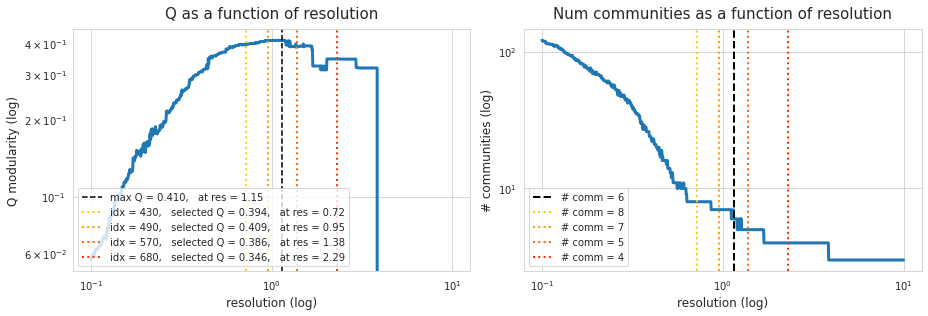

In [20]:
# HIDE CODE


selected_idxs = [430, 490, 570, 680]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='k', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

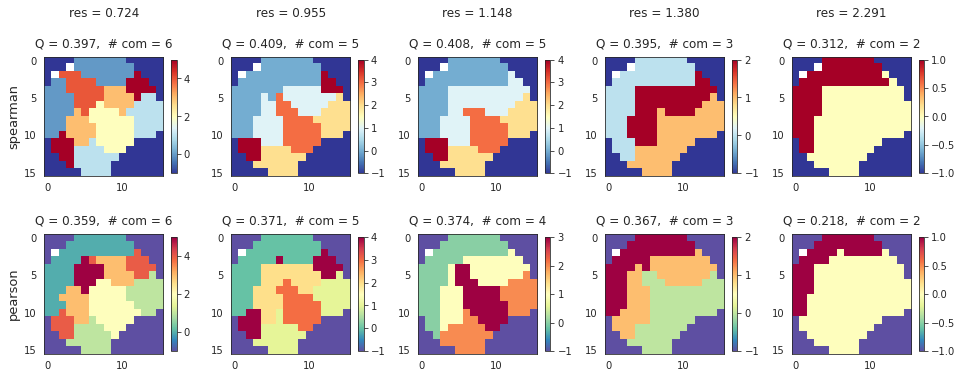

In [78]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(2, len(plot_idxs), figsize=(13.5, 5.5))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    
    g = nx.from_numpy_matrix(spearman[0.8])
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[0, ii].set_title(msg, y=1.03)
    
    
    g = nx.from_numpy_matrix(pearson[0.8])
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
    msg = 'Q = {:.3f},  # com = {:d}'
    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[1, ii].set_title(msg, y=1.03)
    
    if ii == 0:
        axes[0, ii].set_ylabel('spearman', fontsize=13)
        axes[1, ii].set_ylabel('pearson', fontsize=13)
    
    
fig.tight_layout()
plt.show()

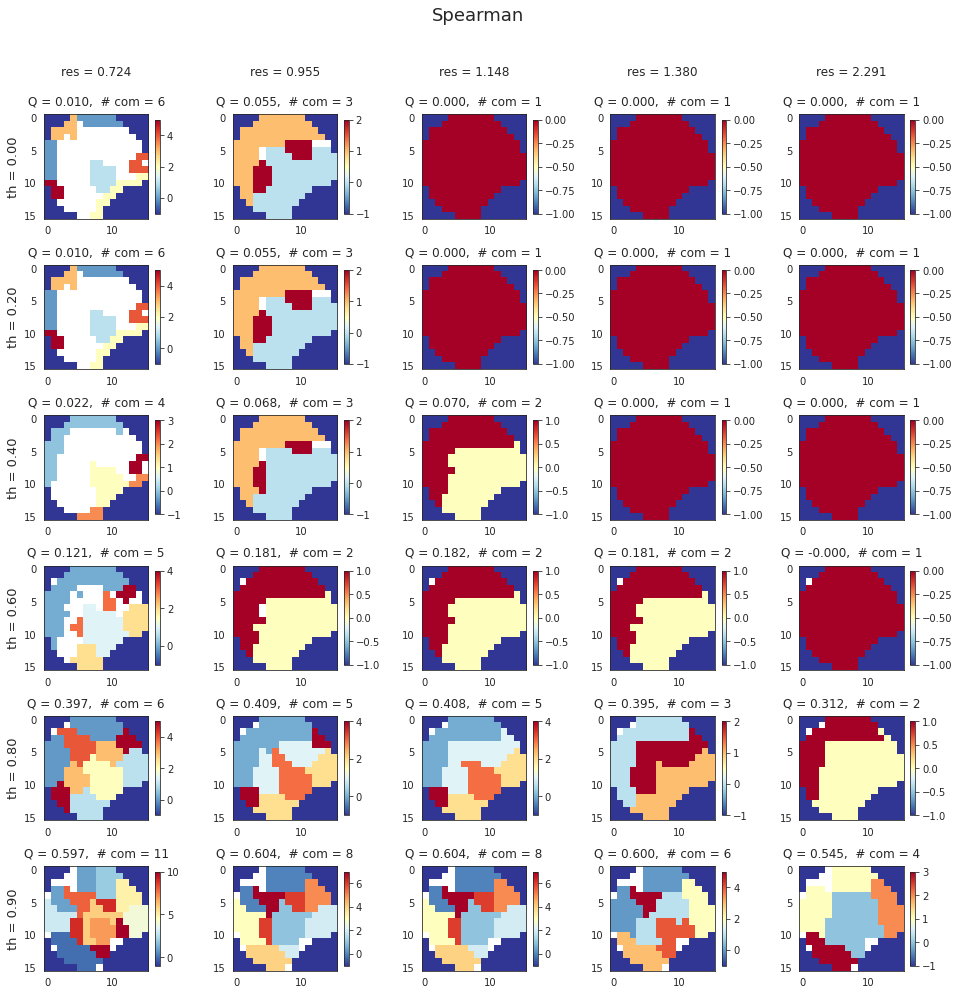

In [87]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(spearman.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='RdYlBu_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Spearman', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

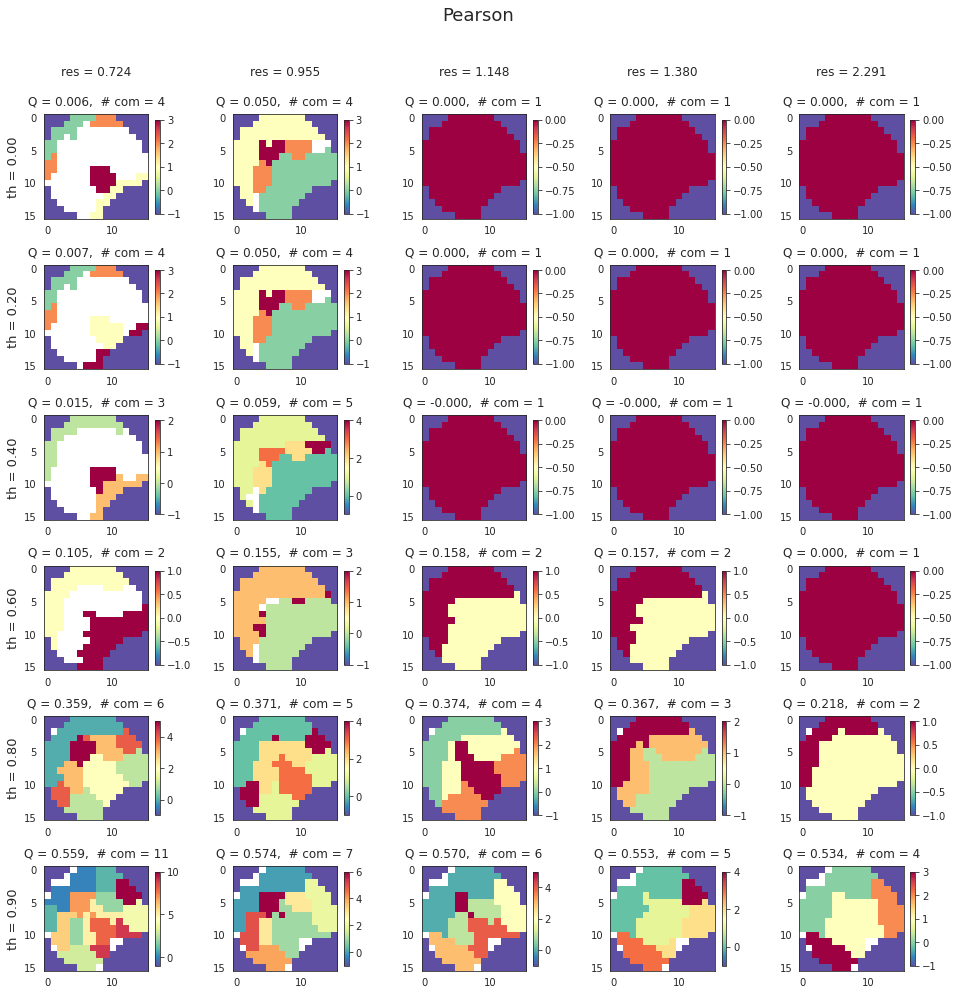

In [88]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(pearson.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Pearson', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

## Finer resolution

In [89]:
size = 32
widths = [int(np.ceil(item / size)) for item in ca.shape[:2]]
nt = ca.shape[-1]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(32, 32, 22000)

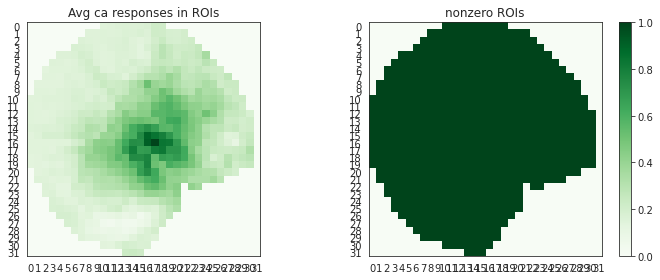

In [90]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[data>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [91]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [92]:
pearson_corr = df.corr('pearson').values
spearman_corr = df.corr('spearman').values

np.fill_diagonal(pearson_corr, 0)
np.fill_diagonal(spearman_corr, 0)

thresholds = [0., 0.2, 0.4, 0.6, 0.8, 0.9]
pearson, spearman = {}, {}
for th in thresholds:
    pmat = pearson_corr.copy()
    smat = spearman_corr.copy()
    pmat[pmat<th] = 0.
    smat[smat<th] = 0.
    pearson[th] = pmat
    spearman[th] = smat

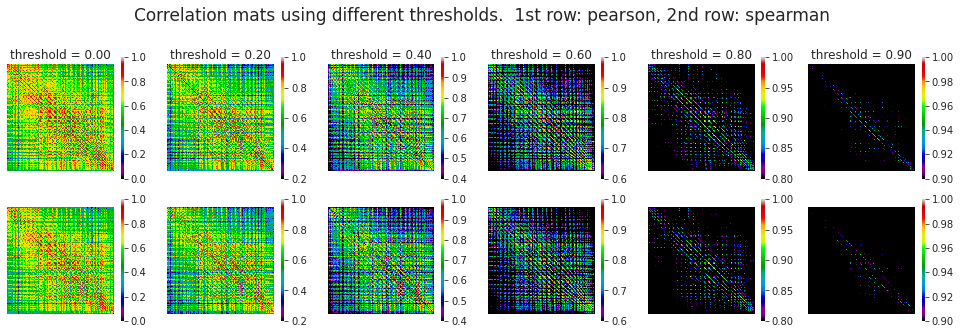

In [93]:
fig, axes = plt.subplots(2, len(thresholds), figsize=(13.5, 4.5))

for i, th in enumerate(thresholds):
    sns.heatmap(
        pearson[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40},
        ax=axes[0, i]
    )
    axes[0, i].set_aspect('equal')
    axes[0, i].set_axis_off()
    axes[0, i].set_title('threshold = {:.2f}'.format(th))
    sns.heatmap(
        spearman[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40},
        ax=axes[1, i]
    )
    axes[1, i].set_aspect('equal')
    axes[1, i].set_axis_off()

msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
fig.suptitle(msg, y=1.02, fontsize=17)
fig.tight_layout()
plt.show()

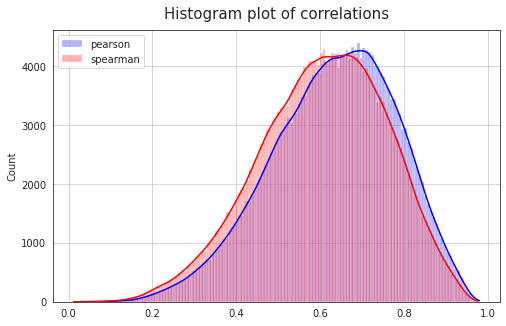

In [94]:
xp = np.triu(pearson_corr)
xs = np.triu(spearman_corr)
xp = xp.flatten()
xs = xs.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.3, label='pearson')
sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.3, label='spearman')
plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [95]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}

g = nx.from_numpy_matrix(spearman[0.8])

In [96]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

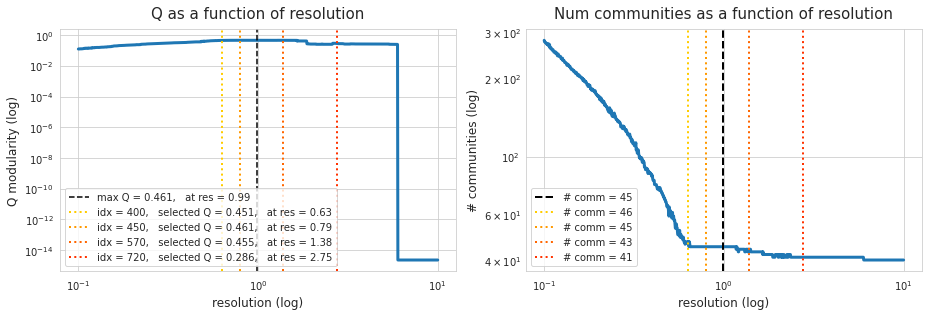

In [99]:
# HIDE CODE


selected_idxs = [400, 450, 570, 720]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='k', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

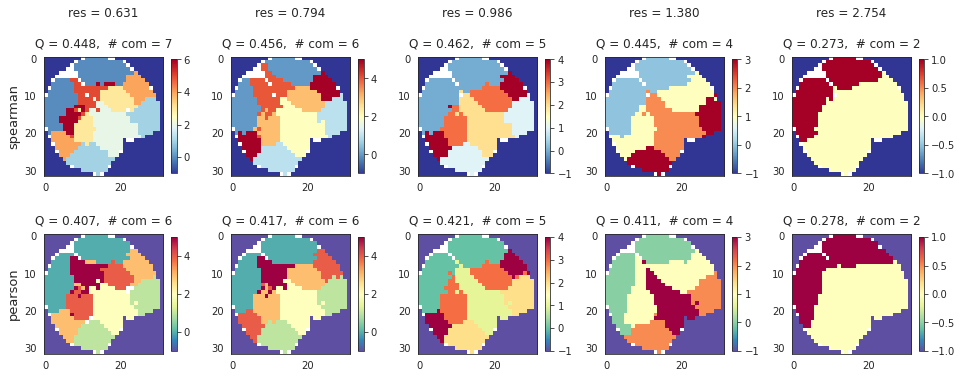

In [100]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(2, len(plot_idxs), figsize=(13.5, 5.5))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    
    g = nx.from_numpy_matrix(spearman[0.8])
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[0, ii].set_title(msg, y=1.03)
    
    
    g = nx.from_numpy_matrix(pearson[0.8])
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
    msg = 'Q = {:.3f},  # com = {:d}'
    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[1, ii].set_title(msg, y=1.03)
    
    if ii == 0:
        axes[0, ii].set_ylabel('spearman', fontsize=13)
        axes[1, ii].set_ylabel('pearson', fontsize=13)
    
    
fig.tight_layout()
plt.show()

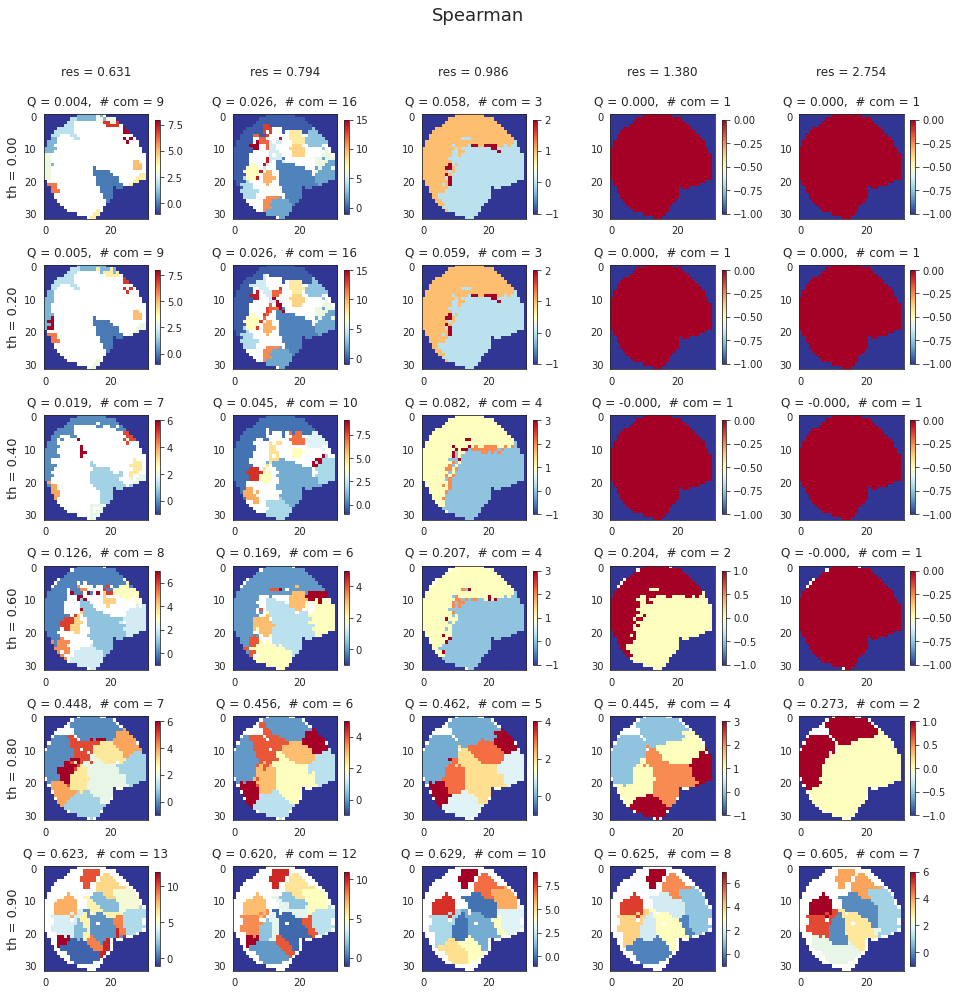

In [101]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(spearman.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='RdYlBu_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Spearman', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

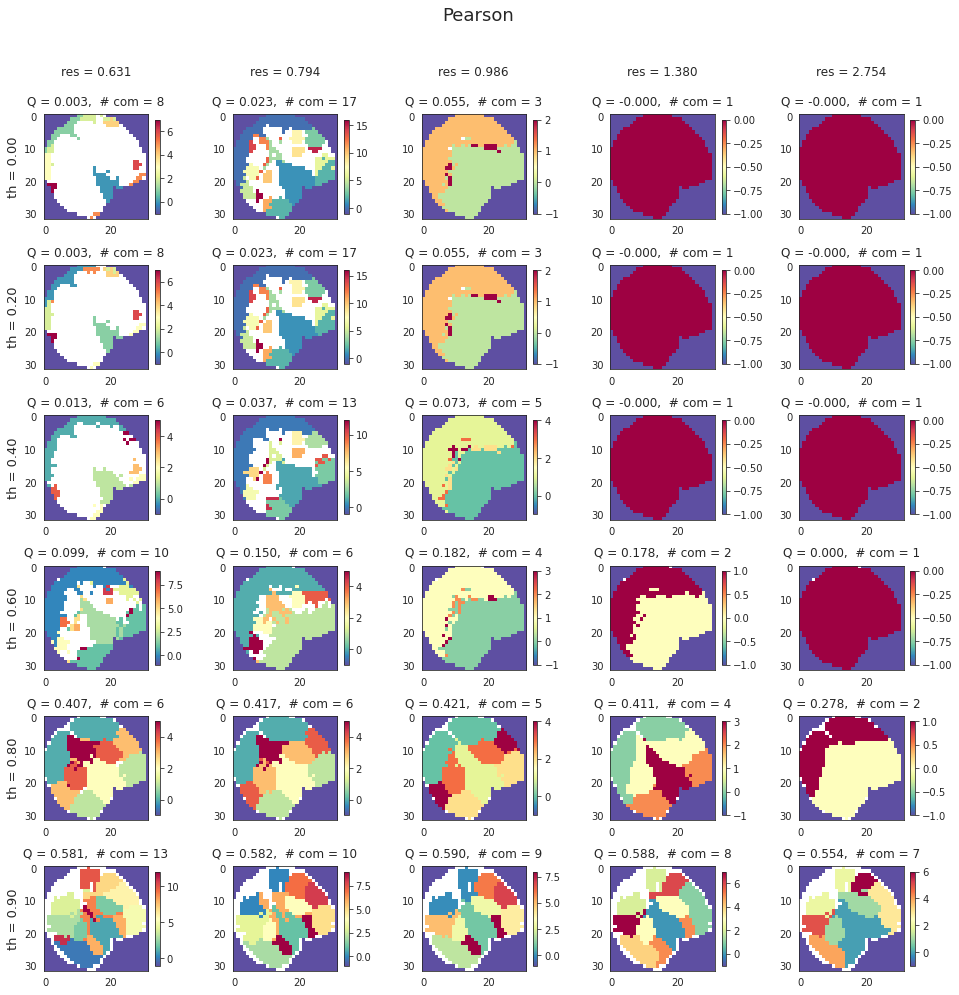

In [102]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(pearson.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Pearson', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

## Discussion

...